In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster, wait
import dask.array as da
import matplotlib.pyplot as plt
import cmocean
from MHW_daily_calcs import *

#### Calculate equivalent SST thresholds that applied to raw SST to see if they are smooth in time

In [2]:
climyrs=[1993,2023]
qtile=0.90
smoothmethod='tri'
window=10
delt=5
#tropical location:
iy=115
ix=200

In [3]:
cluster = LocalCluster(n_workers=6,threads_per_worker=1,dashboard_address='localhost:54924')
client = Client(cluster)

/home/ords/crd/ccrn/reo000/miniconda3/envs/py12MHW/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 54924 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44749 instead
  warnings.warn(


In [4]:
flistclim = [fnameCanESMClim(workdir,climyrs[0],climyrs[-1],mm) for mm in range(1,13)]
fclim=xr.open_mfdataset(flistclim,combine='nested',concat_dim='month',parallel=True,decode_times=False)

In [5]:
method='tri'
halfwin=10

In [6]:
flclimS=[fnameCanESMClimSmooth(workdir,climyrs[0],climyrs[-1],mm, method, halfwin) for mm in range(1,13)]
fclimS=xr.open_mfdataset(flclimS,combine='nested',concat_dim='month',parallel=True,decode_times=False)

(0.0, 366.0)

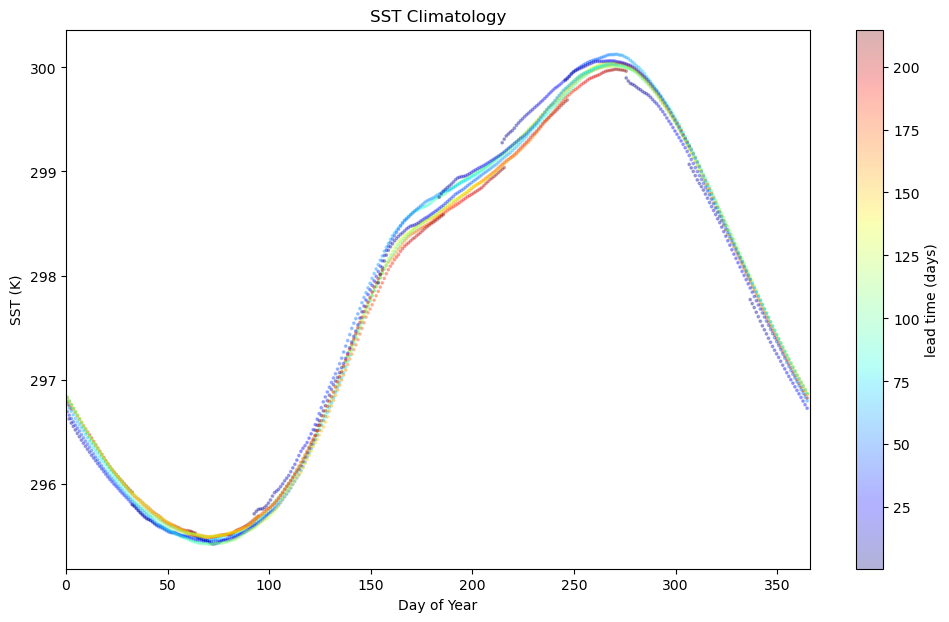

In [7]:
#clim only
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fclim.leadtime.values/24
    t=t%365
    m=ax.scatter(t,fclim.tso.isel(month=mm-1,lat=iy,lon=ix).values,c=fclim.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Climatology')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

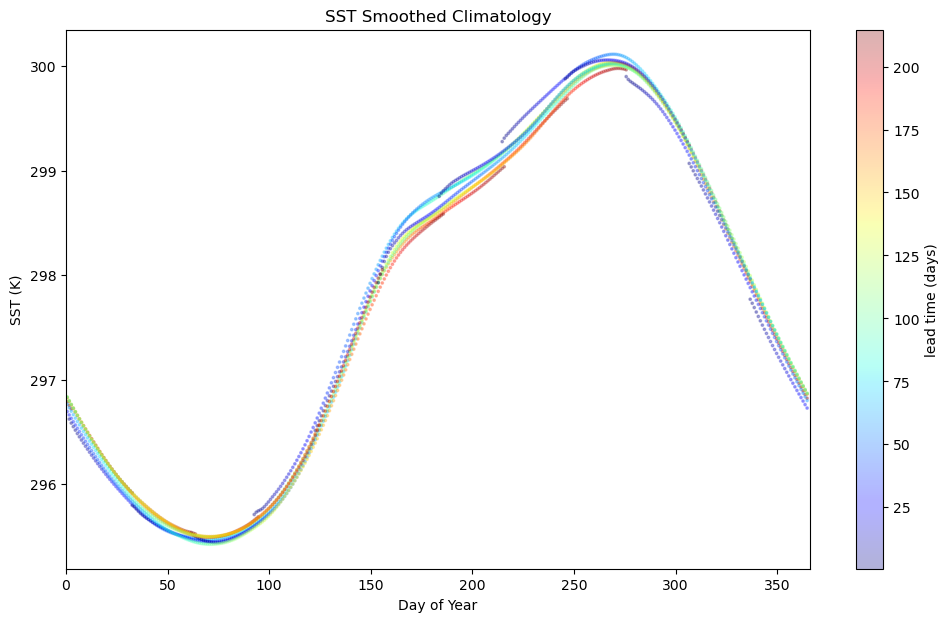

In [8]:
#clim only
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fclimS.leadtime.values/24
    t=t%365
    m=ax.scatter(t,fclimS.tso.isel(month=mm-1,lat=iy,lon=ix).values,c=fclimS.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Smoothed Climatology')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

### now detrended version

first check trends

In [9]:
flistb=[[fnameCanESMDetrFitByLead(workdir, climyrs[0],climyrs[-1], ilead, yind) for yind in [0,60,120]] for ilead in range(0,215)]
fb=xr.open_mfdataset(flistb,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)
desstr=f'_ClimS{smoothmethod}{window}'
flistbS0=[[fnameCanESMDetrFitByLead(workdir, climyrs[0],climyrs[-1], ilead, yind,desstr) for yind in [0,60,120]] for ilead in range(0,215)]
fbS0=xr.open_mfdataset(flistbS0,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)
flistbS=[[fnameCanESMDetrFitByLeadS(workdir, climyrs[0],climyrs[-1], ilead, yind,'tri',10,desstr) for yind in [0,60,120]] for ilead in range(0,215)]
fbS=xr.open_mfdataset(flistbS,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)

2024-11-27 22:26:20,904 - distributed.worker - ERROR - Compute Failed
Key:       open_dataset-a5dff794-1652-486d-a7ce-bd7e235d4375
State:     executing
Function:  execute_task
args:      ((<function apply at 0x147fb4c456c0>, <function open_dataset at 0x147f96210220>, ['/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/fitDetrByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L107_j120_ocean_1d_surface_tso.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [])], ['decode_times', False]])))
kwargs:    {}
Exception: "FileNotFoundError(2, 'No such file or directory')"
Traceback: '  File "/home/ords/crd/ccrn/reo000/miniconda3/envs/py12MHW/lib/python3.12/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^\n  File "/home/ords/crd/ccrn/reo000/miniconda3/envs/py12MHW/lib/python3.12/site-packages/xarray/backends/api.py", line 611, in open_dataset\n    backend_ds = backend.open_datase

FileNotFoundError: [Errno 2] No such file or directory: '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/fitDetrByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L107_j120_ocean_1d_surface_tso.nc'

In [ ]:
flistbS[0][0]

In [ ]:
fb.leadtime

In [ ]:
# trend only
fig,ax=plt.subplots(1,1,figsize=(12,7))
t=fb.leadtime.values # already in days in this file
ax.plot(t,fb.fit.isel(b=1,lat=iy,lon=ix),'k.',zorder=1)
m=ax.scatter(t,fbS0.fit.isel(b=1,lat=iy,lon=ix),c=fbS0.leadtime.values,s=3,cmap=plt.get_cmap('jet'),zorder=2)
ax.plot(t,fbS.fit.isel(b=1,lat=iy,lon=ix),'k-',zorder=3,alpha=.5)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Trend')
ax.set_xlabel('Lead Time (days)')
ax.set_ylabel('SST Trend (K/month)')
ax.set_xlim(0,215)

In [ ]:
plt.pcolormesh(fbS.fit.isel(b=1,leadtime=1)-fb.fit.isel(b=1,leadtime=1))
plt.colorbar()

In [ ]:
# detrended threshold only
flistthresh=[[fnameCanESMAnomDetrQtile(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile,False,False) for yind in [0,60,120]] for ilead in range(0,215)]
fthr=xr.open_mfdataset(flistthresh,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)
flistthreshS=[[fnameCanESMAnomDetrQtile(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile,True,True,method,halfwin,delt=5) for yind in [0,60,120]] for ilead in range(0,215)]
fthrS=xr.open_mfdataset(flistthreshS,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)

In [ ]:
fthr

In [ ]:
fthrS

In [ ]:
flistthreshS[0]

In [ ]:
fnameCanESMAnomDetrQtile(workdir, climyrs[0],climyrs[-1], 5, 0, qtile,True,True,method,halfwin,delt=5)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fthr.qt2.isel(month=mm-1,lat=iy,lon=ix),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Threshold for Detrended Anomalies: 3 month')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fthrS.qt2.isel(month=mm-1,lat=iy,lon=ix),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Smoothed SST Threshold for Detrended Anomalies: 3 month')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fthr.qt1.isel(month=mm-1,lat=iy,lon=ix),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Threshold for Detrended Anomalies: 1 month')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fthrS.qt1.isel(month=mm-1,lat=iy,lon=ix),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Smoothed SST Threshold for Detrended Anomalies: 1 month')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

In [ ]:
# ball: clim + qt + max adjustment due to trend (overestimate)
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fclim.tso.isel(month=mm-1,lat=iy,lon=ix).values+fthr.qt2.isel(month=mm-1,lat=iy,lon=ix)-\
                 fb.fit.isel(b=1,lat=iy,lon=ix).values*(30*12),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Indiv SST Threshold with max trend subtraction (~30 yrs)= Climatology + Anomaly Threshold+Trend*30 yrs')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

In [ ]:
# ball: clim + qt + max adjustment due to trend (overestimate)
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fclimS.tso.isel(month=mm-1,lat=iy,lon=ix).values+fthrS.qt2.isel(month=mm-1,lat=iy,lon=ix)-\
                 fbS.fit.isel(b=1,lat=iy,lon=ix).values*(30*12),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Smoothed SST Threshold with max trend subtraction (~30 yrs)= Climatology + Anomaly Threshold+Trend*30 yrs')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

In [ ]:
# ball: clim + qt + max adjustment due to trend (overestimate)
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fclimS.tso.isel(month=mm-1,lat=iy,lon=ix).values+fthrS.qt2.isel(month=mm-1,lat=iy,lon=ix)-\
                 fbS.fit.isel(b=1,lat=iy,lon=ix).values*(30*12),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Smoothed SST Threshold with max trend subtraction (~30 yrs)= Climatology + Anomaly Threshold+Trend*30 yrs')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(180,240)
ax.set_ylim(300,302)

In [ ]:
fb.close(); fclim.close(); 
fthr.close()
fbS.close(); fclimS.close(); 
fthrS.close()

In [ ]:
client.close()

In [ ]:
cluster.close()